# Реализация K-Means
Воробьёв Сергей, 204

### Задания
0. Реализовать KMeans используя Numpy+MatPlotLib
1. Исследовать зависимость от начальной инициализации
2. Исследовать для каких задач подходит/не подходит
3. Предложить и исследовать стратегию выбора числа класстеров
4. Исследовать зависимость (скорости настройки) от объема данных/сложности задачи
5. Предложить эвристику для визуализации матрицы обратных расстояний

In [77]:
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from sklearn.datasets import make_blobs #for synthetic tests
from IPython.display import clear_output
import seaborn as sns; sns.set()

from matplotlib import colors
cmap1 = colors.ListedColormap(['tab:blue', 'tab:orange', 'tab:green', 'tab:red',
                               'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray',
                               'tab:olive', 'tab:cyan'])

### Задание 0

Для начала реализуем класс K-means:

In [78]:
class KMeans():
    def __init__(self, n_clusters, epsilon=1e-3, init='k-means++'):
        import numpy as np
        self.n_clusters = n_clusters
        self.mu = np.array([])
        self.init = init
        self.epsilon = epsilon
        
    def _init_mu(self, X, k, init='k-means++'):
        if init == 'random':
            mu = X.copy()
            np.random.shuffle(mu)
            return mu[:k]
        if init == 'k-means++':
            mu = []
            initial_index = np.random.choice(range(X.shape[0]), )
            mu.append(X[initial_index, :].tolist())
            for i in range(k - 1):
                distance = np.sum((np.array(mu) - X[:, None, :])**2, axis = 2)
                dist_min = np.min(distance, axis = 1)
                index_max = np.argmax(dist_min, axis = 0)
                mu_new = X[index_max, :]
                mu.append(mu_new.tolist())
            return np.array(mu)

            
        
    def closest_centroid(self, X):
        y = np.argmin(np.sqrt(((X - self.mu[:, np.newaxis])**2).sum(axis=2)), axis=0)
        return y
    
    def move_centroids(self, X, y):
        return np.array([X[y==k].mean(axis=0) for k in range(self.mu.shape[0])])
    
    def fit(self, X, n_iter = 10):
        self.X = X
        self.mu = self._init_mu(self.X, self.n_clusters, self.init)
        #for _ in tqdm(range(n_iter)):
        for _ in range(n_iter):
            self.y = self.closest_centroid(self.X)
            self.mu_new = self.move_centroids(self.X, self.y)
            if np.sqrt(((self.mu - self.mu_new)**2).sum(axis=0)).sum(axis=0) < self.epsilon:
                break
            self.mu = self.mu_new
        clear_output()
        
    def predict(self, X):
        return self.closest_centroid(X)
    

Инициализируем модель и тестируем ее на синтетических данных:

In [79]:
points, _ = make_blobs(n_samples=500, centers=5, cluster_std=1, n_features=3, random_state=1)

md1 = KMeans(5)
md1.fit(points)
C = md1.mu

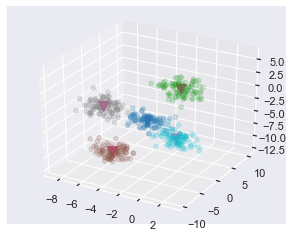

In [80]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(points[:, 0], points[:, 1], points[:, 2],
            c = md1.closest_centroid(points), cmap=cmap1, alpha = 0.2)
ax.scatter(C[:, 0], C[:, 1], C[:, 2],
            c='deeppink', s=100, marker='v')
plt.show()

### Задание 1

В классе я реализовал два основных метода инициализации центроидов. Первый случайно выбирает центроиды `init='random'`, второй выбирает их как можно дальше друг от друга `init=k-means++`. Сравним их:

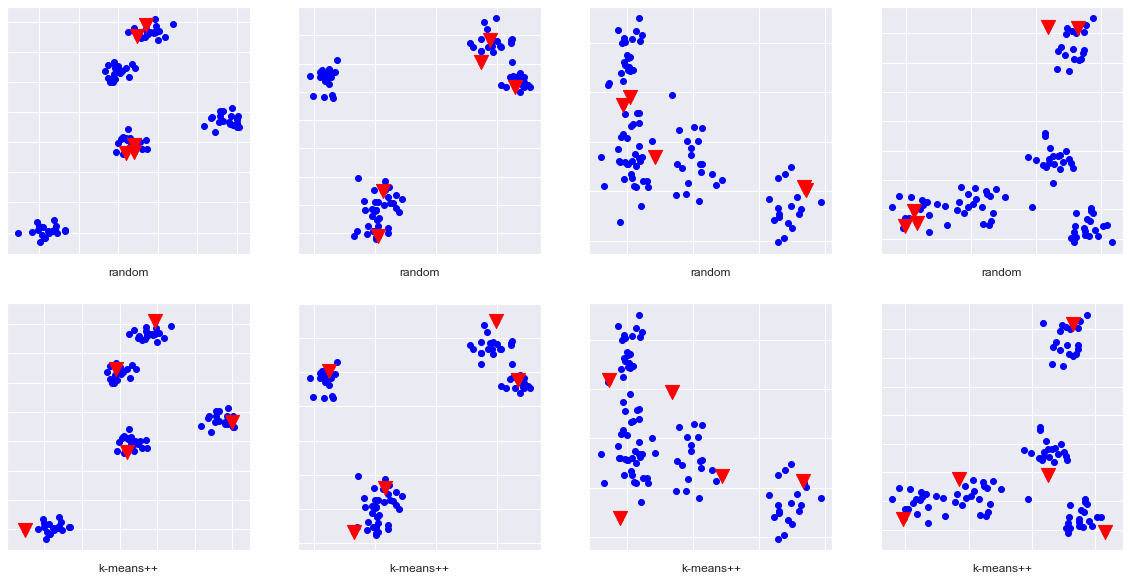

In [81]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

md2 = KMeans(5)

for i, ax in enumerate(axs[0]):
    ax.set(xlabel='random')
    X, _ = make_blobs(n_samples=100, centers=5,
                      cluster_std=0.5+i*0.2, n_features=3, random_state=239+i)
    C = md2._init_mu(X, 5, init='random')
    ax.scatter(X[:,0], X[:,1], c='blue')
    ax.scatter(C[:,0], C[:,1], c='red', s = 200, marker='v')
    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])

for i, ax in enumerate(axs[1]):
    ax.set(xlabel='k-means++')
    X, _ = make_blobs(n_samples=100, centers=5,
                      cluster_std=0.5+i*0.2, n_features=3, random_state=239+i)
    C = md2._init_mu(X, 5, init='k-means++')
    ax.scatter(X[:,0], X[:,1], c='blue')
    ax.scatter(C[:,0], C[:,1], c='red', s = 200, marker='v')
    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])

Можно заметить, что в первом случае (`random`) центроиды могут выбираться слишком близко друг к другу, что негативно сказывается на кластеризации. Во втором случае (`k-means++`) центроиды выбираются далеко друг от друга и вероятность правильной кластеризации выше:

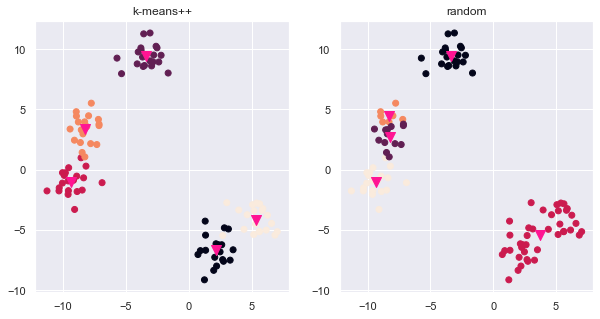

In [82]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
X, _ = make_blobs(n_samples=100, centers=5, cluster_std=1, n_features=3, random_state=111)

md1 = KMeans(5, init='k-means++')
md2 = KMeans(5, init='random')

md1.fit(X)
md2.fit(X)

c1 = md1.mu
c2 = md2.mu

ax1.scatter(X[:, 0], X[:, 1], c = md1.closest_centroid(X), alpha = 1)
ax1.scatter(c1[:, 0], c1[:, 1], c='deeppink', s=100, marker='v', label='k-means++')
ax1.set_title('k-means++')

ax2.scatter(X[:, 0], X[:, 1], c = md2.closest_centroid(X), alpha = 1)
ax2.scatter(c2[:, 0], c2[:, 1], c='deeppink', s=100, marker='v', label='random')
ax2.set_title('random')

plt.show()

Однако, очевидно, что, метод `k-means++` требует значительно больше вычислений, чем `random`, следовательно для каждой задачи нужно подбирать этот параметр индивидуально.

### Задание 2

Так как KMeans – простой, неконтролируемый метод обучения, мы можем использовать его для предварительного анализа и обработки данных, выявления особенностей, кластеризации и классификации.

На датасете с цветками ириса попробуем выяснить, какие особенности лучше всего разделяют классы и по каким признакам их лучше классифицировать:

In [83]:
from sklearn import datasets
import pandas as pd

In [84]:
iris_data = datasets.load_iris()
iris = iris_data.data[:, :4]
iris_y = iris_data.target

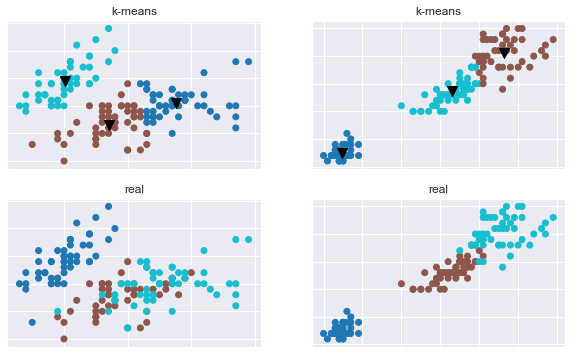

In [85]:
md_iris1 = KMeans(3)
md_iris2 = KMeans(3)

md_iris1.fit(iris[:, 0:2])
c1 = md_iris1.mu

md_iris2.fit(iris[:, 2:4])
c2 = md_iris2.mu

fig, axs = plt.subplots(2, 2, figsize=(10, 6))

for i in range(2):
    axs[0, i].get_xaxis().set_ticklabels([])
    axs[0, i].get_yaxis().set_ticklabels([])
    axs[0, i].set_title('k-means')
    axs[1, i].get_xaxis().set_ticklabels([])
    axs[1, i].get_yaxis().set_ticklabels([])
    axs[1, i].set_title('real')


axs[0, 0].scatter(iris[:, 0], iris[:, 1], cmap=cmap1, c = md_iris1.closest_centroid(iris[:, 0:2]))
axs[0, 0].scatter(c1[:, 0], c1[:, 1], s=100, c='black', marker='v')

axs[0, 1].scatter(iris[:, 2], iris[:, 3], cmap=cmap1, c = md_iris2.closest_centroid(iris[:, 2:4]))
axs[0, 1].scatter(c2[:, 0], c2[:, 1], s=100, c='black', marker='v')

axs[1, 0].scatter(iris[:, 0], iris[:, 1], cmap=cmap1, c = iris_y)

axs[1, 1].scatter(iris[:, 2], iris[:, 3], cmap=cmap1, c = iris_y)


plt.show()

Можно заметить, что выбирая 2 и 3 столбцы как признаки наши классы разделяются намного лучше, в то время как столбцы 0 и 1 плохо подходят для классификации. Эти выводы мы можем использовать для выбора признаков, по которым мы будем классифицировать выборку обучаемыми моделями, например решающими деревьями.

С помощью KMeans можно объединять данные в кластеры (или даже кластеры в мегакластеры).  
Попробуем уменьшить количество цветов в изображении, объединяя похожие цвета в один кластер:

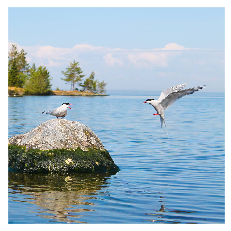

In [86]:
from skimage import io
import matplotlib.image as image
image = io.imread('data/birds.jpg')
plt.axes(xticks=[], yticks=[])
plt.imshow(image);
plt.show()
rows = image.shape[0]
cols = image.shape[1]
image = image.reshape(rows*cols, 3)

In [87]:
compressor = KMeans(n_clusters=12, init='random')
%time compressor.fit(image, n_iter=20)

CPU times: user 12.6 s, sys: 2.4 s, total: 15 s
Wall time: 15.2 s


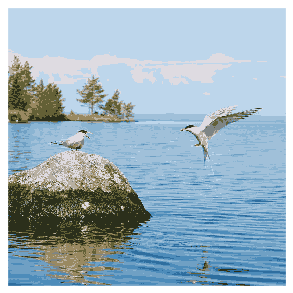

In [88]:
compressed_image = compressor.mu[compressor.closest_centroid(compressor.X)]
compressed_image = np.clip(compressed_image.astype('uint8'), 0, 255)
compressed_image = compressed_image.reshape(rows, cols, 3)
plt.rcParams['figure.figsize'] = (5, 7)
plt.axes(xticks=[], yticks=[])
plt.imshow(compressed_image);

Из-за своих особенностей KMeans хорошо подходит для задач кластеризации и часто подходит для задач классификации, где есть не очень много разнотипных признаков и метрика в пространстве признаков задается не слишком сложно.  
KMeans плохо подходит для других задач машинного обучения, например регрессии и прогнозирования, однако может использоваться для предварительного анализа данных.

### Задание 3

Самым очевидным вариантом является простой перебор параметра `n_clusters` и поиск оптимального значения. Под оптимальным будем понимать такой k, при котором достигается минимально возможное время настройки при минимально возможном значении функции потерь. В качестве функции потерь возьмем сумму расстояний точек до их кластеров.

In [89]:
import time
X, y = make_blobs(n_samples=1000, n_features=20, centers=13, random_state=42, cluster_std=1)

time_intervals = []
loss = []

for k in range(4, 30):
    md = KMeans(k)
    time_start = time.time()
    md.fit(X)
    time_intervals.append(time.time() - time_start)
    loss.append( np.sum([np.sum((X[md.closest_centroid(X)==c] - md.mu[c])**2) for c in range(k)]) )

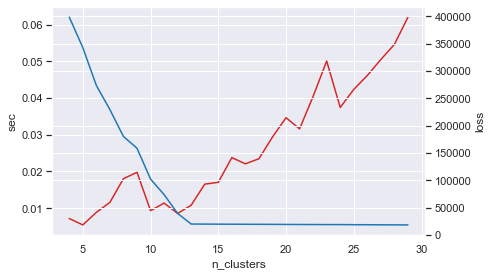

In [97]:
x = np.arange(4, 30)
fig, ax1 = plt.subplots(figsize=(7, 4))

color = 'tab:red'
ax1.set_xlabel('n_clusters')
ax1.set_ylabel('sec')
ax1.plot(x, time_intervals, color=color)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('loss')
ax2.plot(x, loss, color=color)
ax2.tick_params(axis='y')

fig.tight_layout()
plt.show()

Видим, что оптимальное число кластеров для нашей задачи – 13. Собственно, так и были распределены кластеры точек.

### Задание 4

Посмотрим на зависимость скорости настройки от объема/сложности данных

Объем:

In [98]:
intervals = []
for i in range(1, 1000):
    X, _ = make_blobs(n_samples=100*i, centers=5, cluster_std=1, n_features=2)
    md = KMeans(5)
    t1 = time.time()
    md.fit(X)
    intervals.append(time.time() - t1)

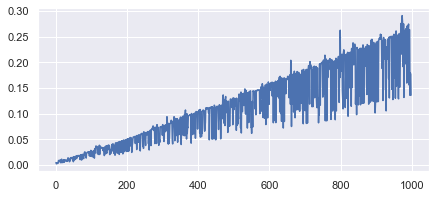

In [99]:
plt.figure(figsize=(7, 3))
plt.plot(intervals)
plt.show()

Видим, что скорость настройки зависит линейно от объема данных

Теперь посмотрим на зависимость от сложности:

In [100]:
from tqdm.notebook import tqdm

In [101]:
intervals = []
for i in range(10, 200, 10):
    X, _ = make_blobs(n_samples=250, centers=10, cluster_std=1, n_features=i)
    md = KMeans(i)
    t1 = time.time()
    md.fit(X)
    intervals.append(time.time() - t1)
    print(i)
clear_output()

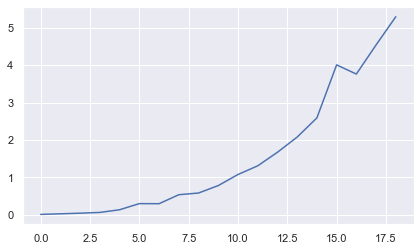

In [103]:
plt.figure(figsize=(7, 4))
plt.plot(intervals)
plt.show()

Можем заметить полиномиальную зависимость скорости настройки от сложности данных.

### Задание 5

Вычислим матрицу попарных расстояний и подумаем как лучше всего ее представить:

In [104]:
from scipy.spatial import distance_matrix

In [105]:
k = 5

In [106]:
def heatmap(data):
    plt.figure(figsize=(6, 5))
    plt.axes(xticks=[], yticks=[])
    im = plt.imshow(data, cmap='hot', interpolation='nearest')
    plt.colorbar(im)
    plt.show()

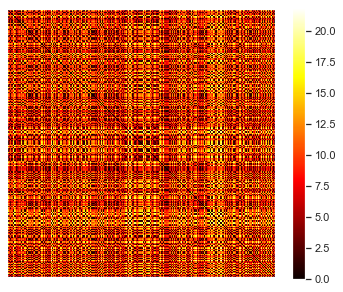

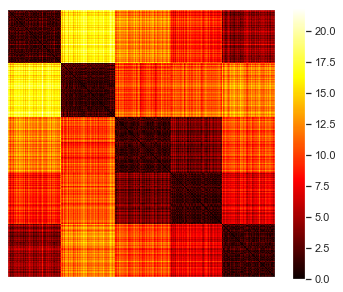

In [107]:
X, _ = make_blobs(n_samples=500, centers=k, cluster_std=1, n_features=2)
md = KMeans(k)
md.fit(X)
data = np.concatenate((X, md.closest_centroid(X)[:, np.newaxis]), axis=1)
data = data[np.argsort(data[:,2])]
dmX = distance_matrix(X, X)
dm = distance_matrix(data[:, 0:2], data[:, 0:2])

heatmap(dmX)
heatmap(dm)

Подумаем над тем, как логично упорядочить кластеры между собой. Самым очевидным кажется расположить кластеры в порядке их убывания по близости к первому кластеру:

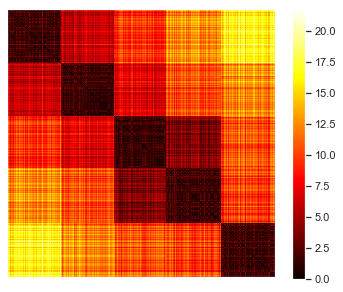

In [108]:
nd = data[data[:,2]==0]
od = data[data[:,2]!=0]
for i in range(k):
    min_norm = 10**10
    min_index = -1
    for j in range(k):
        if od[od[:,2]==j].shape[0]:
            norm = np.linalg.norm( distance_matrix(nd[nd[:,2]==0], od[od[:,2]==j]) )
            if norm < min_norm:
                min_norm = norm
                min_index = j
    nd = np.concatenate((nd, od[od[:,2] == min_index]), axis=0)
    od = od[od[:,2]!=min_index]

dm = distance_matrix(nd, nd)
heatmap(dm)

Таким образом можно визуально оценить расположение кластеров относительно первого и оценить,  
насколько далеко друг от друга все они расположены.